In [0]:
import pandas as pd

df = pd.read_csv("/dbfs/FileStore/shared_uploads/th287@duke.edu/Churn_Modelling-3.csv")
df.head()

Out[2]:

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### EDA

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 RowNumber 10000 non-null int64 
 1 CustomerId 10000 non-null int64 
 2 Surname 10000 non-null object 
 3 CreditScore 10000 non-null int64 
 4 Geography 10000 non-null object 
 5 Gender 10000 non-null object 
 6 Age 10000 non-null int64 
 7 Tenure 10000 non-null int64 
 8 Balance 10000 non-null float64
 9 NumOfProducts 10000 non-null int64 
 10 HasCrCard 10000 non-null int64 
 11 IsActiveMember 10000 non-null int64 
 12 EstimatedSalary 10000 non-null float64
 13 Exited 10000 non-null int64 
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB

In [0]:
# check missing values
df.isnull().sum()

Out[4]: RowNumber 0
CustomerId 0
Surname 0
CreditScore 0
Geography 0
Gender 0
Age 0
Tenure 0
Balance 0
NumOfProducts 0
HasCrCard 0
IsActiveMember 0
EstimatedSalary 0
Exited 0
dtype: int64

Out[7]:

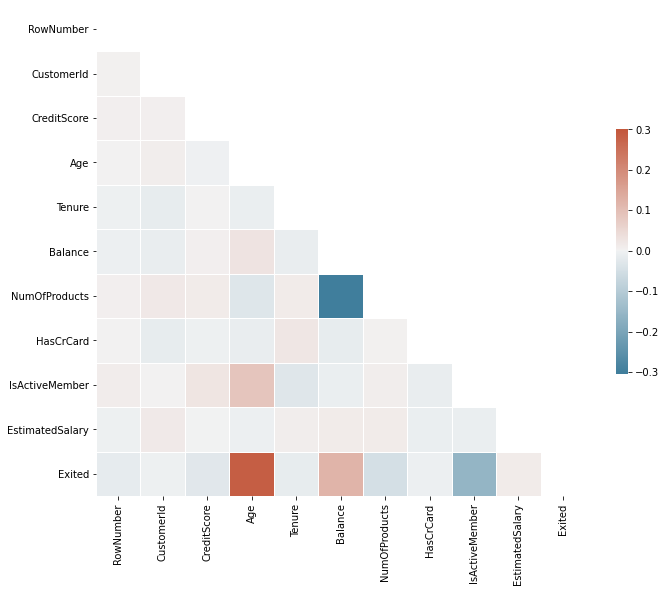

<AxesSubplot:>

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
corr = df.corr()
mask = np.triu(np.ones_like(corr,dtype=bool))

f, ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(230,20,as_cmap=True)

sns.heatmap(corr,mask=mask, cmap=cmap, vmax=.3,center=0,square=True,linewidths=.5,cbar_kws = {'shrink':.5})

### Data Preprocessing

In [0]:
# print dimensions of categorical columns
a = df.select_dtypes(object).columns
for i in a:
    print (i, df[i].nunique())

Surname 2932
Geography 3
Gender 2

In [0]:
# drop useless cols
df.drop(['CustomerId','Surname'],inplace=True,axis=1)

# encode categorical cols
df = pd.get_dummies(df)

In [0]:
# create X, y
X = df.drop('Exited',axis=1)
y = df['Exited']

# Split out the training data
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.6, random_state=123)
 
# Split the remaining data equally into validation and test
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=123)

### Model Fitting

#### Random Forest

In [0]:
import mlflow
import mlflow.pyfunc
import mlflow.sklearn
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from mlflow.models.signature import infer_signature
from mlflow.utils.environment import _mlflow_conda_env
import cloudpickle
import time
 
# The predict method of sklearn's RandomForestClassifier returns a binary classification (0 or 1). 
# The following code creates a wrapper function, SklearnModelWrapper, that uses 
# the predict_proba method to return the probability that the observation belongs to each class. 
 
class SklearnModelWrapper(mlflow.pyfunc.PythonModel):
  def __init__(self, model):
    self.model = model
    
  def predict(self, context, model_input):
    return self.model.predict_proba(model_input)[:,1]
 
# mlflow.start_run creates a new MLflow run to track the performance of this model. 
# Within the context, you call mlflow.log_param to keep track of the parameters used, and
# mlflow.log_metric to record metrics like accuracy.
with mlflow.start_run(run_name='untuned_random_forest'):
  n_estimators = 10
  model = RandomForestClassifier(n_estimators=n_estimators, random_state=np.random.RandomState(123))
  model.fit(X_train, y_train)
 
  # predict_proba returns [prob_negative, prob_positive], so slice the output with [:, 1]
  predictions_test = model.predict_proba(X_test)[:,1]
  auc_score = roc_auc_score(y_test, predictions_test)
  mlflow.log_param('n_estimators', n_estimators)
  # Use the area under the ROC curve as a metric.
  mlflow.log_metric('auc', auc_score)
  wrappedModel = SklearnModelWrapper(model)
  # Log the model with a signature that defines the schema of the model's inputs and outputs. 
  # When the model is deployed, this signature will be used to validate inputs.
  signature = infer_signature(X_train, wrappedModel.predict(None, X_train))
  
  # MLflow contains utilities to create a conda environment used to serve models.
  # The necessary dependencies are added to a conda.yaml file which is logged along with the model.
  conda_env =  _mlflow_conda_env(
        additional_conda_deps=None,
        additional_pip_deps=["cloudpickle=={}".format(cloudpickle.__version__), "scikit-learn=={}".format(sklearn.__version__)],
        additional_conda_channels=None,
    )
  mlflow.pyfunc.log_model("random_forest_model", python_model=wrappedModel, conda_env=conda_env, signature=signature)

/databricks/python/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
 inputs = _infer_schema(model_input)

In [0]:
feature_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns.tolist(), columns=['importance'])
feature_importances.sort_values('importance', ascending=False)

Out[14]:

,importance
Age,0.215996
EstimatedSalary,0.124471
CreditScore,0.123024
Balance,0.122487
RowNumber,0.121765
NumOfProducts,0.111393
Tenure,0.070963
IsActiveMember,0.034457
Geography_Germany,0.020904
HasCrCard,0.017432


In [0]:
print(f'AUC: {roc_auc_score(y_test, model.predict(X_test))}')

AUC: 0.6879327030447405

#### XGBoost

In [0]:
from hyperopt import fmin, tpe, hp, SparkTrials, Trials, STATUS_OK
from hyperopt.pyll import scope
from math import exp
import mlflow.xgboost
import numpy as np
import xgboost as xgb
 
search_space = {
  'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
  'learning_rate': hp.loguniform('learning_rate', -3, 0),
  'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
  'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
  'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
  'objective': 'binary:logistic',
  'seed': 123, # Set a seed for deterministic training
}
 
def train_model(params):
  # With MLflow autologging, hyperparameters and the trained model are automatically logged to MLflow.
  mlflow.xgboost.autolog()
  with mlflow.start_run(nested=True):
    train = xgb.DMatrix(data=X_train, label=y_train)
    validation = xgb.DMatrix(data=X_val, label=y_val)
    # Pass in the validation set so xgb can track an evaluation metric. XGBoost terminates training when the evaluation metric
    # is no longer improving.
    booster = xgb.train(params=params, dtrain=train, num_boost_round=1000,\
                        evals=[(validation, "validation")], early_stopping_rounds=50)
    validation_predictions = booster.predict(validation)
    auc_score = roc_auc_score(y_val, validation_predictions)
    mlflow.log_metric('auc', auc_score)
 
    signature = infer_signature(X_train, booster.predict(train))
    mlflow.xgboost.log_model(booster, "model", signature=signature)
    
    # Set the loss to -1*auc_score so fmin maximizes the auc_score
    return {'status': STATUS_OK, 'loss': -1*auc_score, 'booster': booster.attributes()}
 
# Greater parallelism will lead to speedups, but a less optimal hyperparameter sweep. 
# A reasonable value for parallelism is the square root of max_evals.
spark_trials = SparkTrials(parallelism=10)
 
# Run fmin within an MLflow run context so that each hyperparameter configuration is logged as a child run of a parent
# run called "xgboost_models" .
with mlflow.start_run(run_name='xgboost_models'):
  best_params = fmin(
    fn=train_model, 
    space=search_space, 
    algo=tpe.suggest, 
    max_evals=96,
    trials=spark_trials,
  )

Hyperopt with SparkTrials will automatically track trials in MLflow. To view the MLflow experiment associated with the notebook, click the 'Runs' icon in the notebook context bar on the upper right. There, you can view all runs.
To view logs from trials, please check the Spark executor logs. To view executor logs, expand 'Spark Jobs' above until you see the (i) icon next to the stage from the trial job. Click it and find the list of tasks. Click the 'stderr' link for a task to view trial logs.
 0%| | 0/96 [00:00<?, ?trial/s, best loss=?] /databricks/spark/python/pyspark/rdd.py:980: FutureWarning: Deprecated in 3.1, Use pyspark.InheritableThread with the pinned thread mode enabled.
 warnings.warn(

 0%| | 0/96 [00:01<?, ?trial/s, best loss=?] 2%|▏ | 2/96 [01:06<51:50, 33.09s/trial, best loss: -0.8670025475532741] 3%|▎ | 3/96 [01:08<31:13, 20.14s/trial, best loss: -0.8670025475532741] 4%|▍ | 4/96 [01:11<21:04, 13.75s/trial, best loss: -0.8670025475532741] 5%|▌ | 5/96 [01:14<15:14, 10.05s/trial, best loss: -0.8673913180901569] 6%|▋ | 6/96 [01:15<10:34, 7.05s/trial, best loss: -0.8673913180901569] 7%|▋ | 7/96 [01:22<10:26, 7.04s/trial, best loss: -0.8673913180901569] 8%|▊ | 8/96 [01:51<20:28, 13.96s/trial, best loss: -0.8673913180901569] 9%|▉ | 9/96 [01:57<16:40, 11.50s/trial, best loss: -0.8673913180901569] 10%|█ | 10/96 [02:04<14:30, 10.12s/trial, best loss: -0.8673913180901569] 11%|█▏ | 11/96 [02:08<11:42, 8.26s/trial, best loss: -0.8673913180901569] 12%|█▎ | 12/96 [02:17<11:53, 8.49s/trial, best loss: -0.8673913180901569] 14%|█▎ | 13/96 [02:21<09:52, 7.14s/trial, best loss: -0.8673913180901569] 15%|█▍ | 14/96 [02:30<10:32, 7.71s/trial, best loss: -0.8673913180901569] 16%|█▌ | 15/96 [02:34<08:54, 6.60s/trial, best loss: -0.8673913180901569] 17%|█▋ | 16/96 [02:36<06:57, 5.22s/trial, best loss: -0.8673913180901569] 18%|█▊ | 17/96 [02:39<06:00, 4.56s/trial, best loss: -0.8673913180901569] 19%|█▉ | 18/96 [03:00<12:21, 9.51s/trial, best loss: -0.8673913180901569] 20%|█▉ | 19/96 [03:12<13:10, 10.27s/trial, best loss: -0.8673913180901569] 21%|██ | 20/96 [03:19<11:46, 9.29s/trial, best loss: -0.8673913180901569] 22%|██▏ | 21/96 [03:46<18:16, 14.62s/trial, best loss: -0.8673913180901569] 23%|██▎ | 22/96 [03:47<13:01, 10.56s/trial, best loss: -0.8694568591133502] 24%|██▍ | 23/96 [03:48<09:23, 7.72s/trial, best loss: -0.8715745522817355] 25%|██▌ | 24/96 [03:49<06:50, 5.71s/trial, best loss: -0.8715745522817355] 26%|██▌ | 25/96 [03:59<08:17, 7.01s/trial, best loss: -0.8715745522817355] 29%|██▉ | 28/96 [04:01<03:54, 3.45s/trial, best loss: -0.8715745522817355] 30%|███ | 29/96 [04:02<03:16, 2.93s/trial, best loss: -0.8715745522817355] 31%|███▏ | 30/96 [04:04<02:44, 2.49s/trial, best loss: -0.8715745522817355] 32%|███▏ | 31/96 [04:07<02:51, 2.63s/trial, best loss: -0.8715745522817355] 33%|███▎ | 32/96 [04:10<02:54, 2.73s/trial, best loss: -0.8715745522817355] 34%|███▍ | 33/96 [04:11<02:22, 2.26s/trial, best loss: -0.8715745522817355] 35%|███▌ | 34/96 [04:18<03:43, 3.60s/trial, best loss: -0.8715745522817355] 36%|███▋ | 35/96 [04:19<02:54, 2.86s/trial, best loss: -0.8715745522817355] 39%|███▊ | 37/96 [04:25<02:53, 2.93s/trial, best loss: -0.8715745522817355] 40%|███▉ | 38/96 [04:26<02:22, 2.46s/trial, best loss: -0.8715745522817355] 42%|████▏ | 40/96 [04:31<02:19, 2.49s/trial, best loss: -0.8715745522817355] 43%|████▎ | 41/96 [04:37<03:01, 3.29s/trial, best loss: -0.8715745522817355] 45%|████▍ | 43/96 [04:38<01:56, 2.20s/trial, best loss: -0.8715745522817355] 46%|████▌ | 44/96 [04:40<01:52, 2.16s/trial, best loss: -0.8715745522817355] 47%|████▋ | 45/96 [04:42<01:48, 2.13s/trial, best loss: -0.8715745522817355] 48%|████▊ | 46/96 [04:43<01:32, 1.85s/trial, best loss: -0.8715745522817355] 49%|████▉ | 47/96 [04:45<01:32, 1.90s/trial, best loss: -0.8715745522817355] 50%|█████ | 48/96 [04:46<01:19, 1.66s/trial, best loss: -0.8715745522817355] 51%|█████ | 49/96 [04:53<02:29, 3.17s/trial, best loss: -0.87

In [0]:
best_run = mlflow.search_runs(order_by=['metrics.auc DESC']).iloc[0]
print(f'AUC of Best Run: {best_run["metrics.auc"]}')

AUC of Best Run: 0.8720028320195206

### Model Registry

In [0]:
model_name = "churn_prediction"
model_version = mlflow.register_model(f"runs:/{best_run.run_id}/model", model_name)

time.sleep(15)

Successfully registered model 'churn_prediction'.
2022/03/26 06:01:45 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: churn_prediction, version 1
Created version '1' of model 'churn_prediction'.

In [0]:
from mlflow.tracking import MlflowClient
 
client = MlflowClient()
client.transition_model_version_stage(
  name=model_name,
  version=model_version.version,
  stage="Production",
)

Out[19]: <ModelVersion: creation_timestamp=1648274505954, current_stage='Production', description='', last_updated_timestamp=1648274539106, name='churn_prediction', run_id='c357b36b54ad491a8797f03b641d3b33', run_link='', source='dbfs:/databricks/mlflow-tracking/683857960816058/c357b36b54ad491a8797f03b641d3b33/artifacts/model', status='READY', status_message='', tags={}, user_id='4968811378588310', version='1'>

In [0]:
model = mlflow.pyfunc.load_model(f"models:/{model_name}/production")
print(f'AUC: {roc_auc_score(y_test, model.predict(X_test))}')

AUC: 0.8631014417231196